### The Story

This is about an Insurance company that has provided Health Insurance to its customers, now the company needs help in building a model to predict whether the policyholders (customers) from past year will also be interested in Vehicle Insurance provided by the company again.

Building a model to predict whether a customer would be interested in Vehicle Insurance is extremely helpful for the company because it can then accordingly plan its communication strategy to reach out to those customers and optimise its business model and revenue.

Now, in order to predict, whether the customer would be interested in Vehicle insurance, I will use the below information: demographics (gender, age, region code type), Vehicles (Vehicle Age, Damage), and Policy (Premium, sourcing channel).

Therefore we are interested to predict the response of the customer to take up the insurance (Probability of response 'yes' or '1'). The evaluation metric for this project is ROC_AUC score.

Source of data: https://www.kaggle.com/anmolkumar/health-insurance-cross-sell-prediction?select=train.csv


In [55]:
# importing the necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [56]:
# lets import and explore the dataset:
#insuranc = pd.read_csv('insurance_data.csv')
#insuranc.head()


In [57]:
# to select a small part of data set and save it into a new dataset:
#insurance1=insuranc[:30000]
#insur= insurance1.to_csv('insurance_data1.csv', index=False)


In [58]:
# to read the data:
insurance = pd.read_csv('insurance_data1.csv')
insurance.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [59]:
# to check on the missing values
insurance.isnull().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

In [60]:
# to see the data types and more information
insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    30000 non-null  int64  
 1   Gender                30000 non-null  object 
 2   Age                   30000 non-null  int64  
 3   Driving_License       30000 non-null  int64  
 4   Region_Code           30000 non-null  float64
 5   Previously_Insured    30000 non-null  int64  
 6   Vehicle_Age           30000 non-null  object 
 7   Vehicle_Damage        30000 non-null  object 
 8   Annual_Premium        30000 non-null  float64
 9   Policy_Sales_Channel  30000 non-null  float64
 10  Vintage               30000 non-null  int64  
 11  Response              30000 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 2.7+ MB


In [61]:
# drop 'id' and 'Region_Code'column and then add it later: 
#new_df2['id'] = insurance['id']
#new_df2['Region_Code'] = insurance['Region_Code']


#insurance.drop(['id','Region_Code' ], axis=1, inplace=True)

In [62]:
# to see the object columns
insurence_object=insurance.select_dtypes(include=['object'])
insurence_object

,Gender,Vehicle_Age,Vehicle_Damage
0,Male,> 2 Years,Yes
1,Male,1-2 Year,No
2,Male,> 2 Years,Yes
3,Male,< 1 Year,No
4,Female,< 1 Year,No
...,...,...,...
29995,Male,< 1 Year,No
29996,Male,< 1 Year,Yes
29997,Female,< 1 Year,No
29998,Male,< 1 Year,No


In [63]:
# to apply label encoder to the selected columns:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
insurance.Gender= le.fit_transform(insurance.Gender.values)
insurance.Vehicle_Damage= le.fit_transform(insurance.Vehicle_Damage.values)


In [64]:
# to see the corr of selected columns
#insurance[['Driving_License','Previously_Insured']].corr()

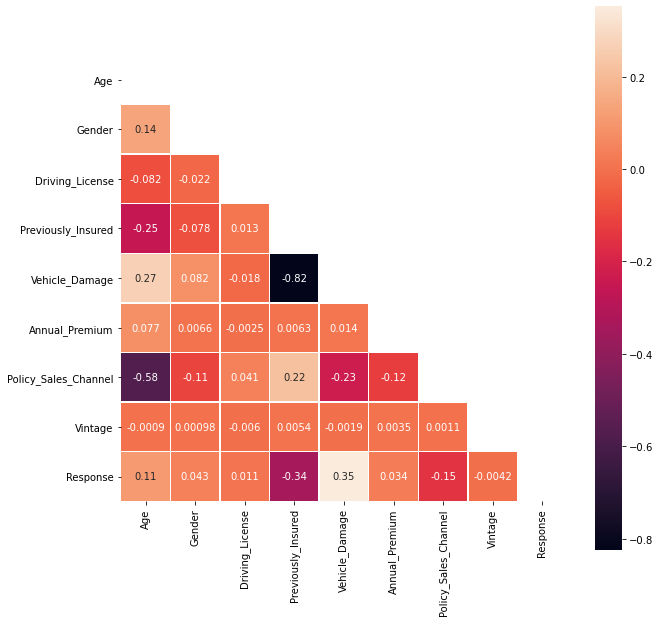

In [65]:
# correlation of selected variables:
f, b = plt.subplots(figsize=(10,10))
corr = insurance[['Age', 'Gender', 'Driving_License',
       'Previously_Insured', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response']].corr()

mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, linewidth=0.3, square=True, annot=True)

In [66]:
# to drop the columns if their corrlation is above .95:

# Select upper triangle of correlation matrix
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] < -0.95)]
to_drop1 = [column for column in upper.columns if any(upper[column] > 0.95)]

print(to_drop)
print(to_drop1)

[]
[]


In [67]:
# apply oneHotEncoder
#from sklearn.preprocessing import OneHotEncoder                              
                              
#enc = OneHotEncoder() # here is (), we can write drop='first' to drop one variable
#categorical = pd.DataFrame(enc.fit_transform(insurance[['Vehicle_Age']]).toarray(), columns = enc.get_feature_names())
#categorical.head()

In [68]:
# to decode and get dummies:

dummies= pd.get_dummies(insurance['Vehicle_Age'])
insurance_1 = pd.concat([insurance, dummies], axis=1).drop(['Vehicle_Age'], axis=1)


In [69]:
insurance_1.drop(['< 1 Year'], axis=1, inplace=True)

In [70]:
insurance_1['Response'].value_counts()

0    26285
1     3715
Name: Response, dtype: int64

In [71]:
insurance_1.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,1-2 Year,> 2 Years
0,1,1,44,1,28.0,0,1,40454.0,26.0,217,1,0,1
1,2,1,76,1,3.0,0,0,33536.0,26.0,183,0,1,0
2,3,1,47,1,28.0,0,1,38294.0,26.0,27,1,0,1
3,4,1,21,1,11.0,1,0,28619.0,152.0,203,0,0,0
4,5,0,29,1,41.0,1,0,27496.0,152.0,39,0,0,0


### Dataset with Standard Scaler 
Standardize features to mean zero and variance one. 

In [72]:
from sklearn.preprocessing import StandardScaler
to_transform = insurance_1[['Age', 'Annual_Premium','Policy_Sales_Channel','Vintage']]
# to select number type columns: data_num = insurance_2.select_dtypes(include=np.number)
transfor = StandardScaler().fit(to_transform)
transform_data= transfor.transform(to_transform)
transform = pd.DataFrame(transform_data, columns = to_transform.columns)
transform.head()
to_select = insurance_1[['Gender', 'Driving_License',
       'Previously_Insured', 'Vehicle_Damage', 'Response', '1-2 Year',
       '> 2 Years']]

insurance_2=pd.concat([transform, to_select], axis=1)

### Dataset with Feature Scaling
This method delas with outliers. This Scaler removes the median and scales the data according to the quantile range (defaults to IQR: Interquartile Range). The IQR is the range between the 1st quartile (25th quantile) and the 3rd quartile (75th quantile). Centering and scaling happen independently on each feature by computing the relevant statistics on the samples in the training set. Median and interquartile range are then stored to be used on later data using the transform method. Outliers can often influence the sample mean / variance in a negative way. Therefore, the median and the interquartile range often give better results as compared to StandardScaler.

In [73]:
from sklearn.preprocessing import RobustScaler

to_fs = insurance_1[['Age', 'Annual_Premium','Policy_Sales_Channel','Vintage']]
to_fs_data= RobustScaler().fit(to_fs)
to_fs_data1 = to_fs_data.transform(to_fs)
fs_data = pd.DataFrame(to_fs_data1, columns= to_fs.columns)

insurance_3 = pd.concat([fs_data, to_select], axis=1)


### Modeling, Prediction, and Evaluation


In [74]:
insurance_3.head()

,Age,Annual_Premium,Policy_Sales_Channel,Vintage,Gender,Driving_License,Previously_Insured,Vehicle_Damage,Response,1-2 Year,> 2 Years
0,0.333333,0.575527,-1.016393,0.434483,1,1,0,1,1,0,1
1,1.666667,0.116141,-1.016393,0.200000,1,1,0,0,0,1,0
2,0.458333,0.432093,-1.016393,-0.875862,1,1,0,1,1,0,1
3,-0.625000,-0.210369,0.016393,0.337931,1,1,1,0,0,0,0
4,-0.291667,-0.284941,0.016393,-0.793103,0,1,1,0,0,0,0


In [75]:
# slpit the data into 80% & 20%

from sklearn.model_selection import train_test_split 

y=insurance_1['Response']

X=insurance_1[['Age','Annual_Premium', 'Policy_Sales_Channel','Vintage',
               'Gender','Driving_License', 'Previously_Insured', 
               'Vehicle_Damage', '1-2 Year', '> 2 Years']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)


#### Application of Logistic Regression on original dataset (not transformed, not normalised)

In [76]:
from sklearn.linear_model import LogisticRegression 

logistic_model=LogisticRegression().fit(X_train, y_train)
response_pred=logistic_model.predict(X_test)
response_pred = pd.Series(response_pred)

y_pred = pd.Series(response_pred, name='response_pred').value_counts()
y_tes = y_test.value_counts()

y_pred

0    6000
Name: response_pred, dtype: int64

In [77]:
pd.concat([y_tes, y_pred], axis=1)


,Response,response_pred
0,5286,6000.0
1,714,NaN


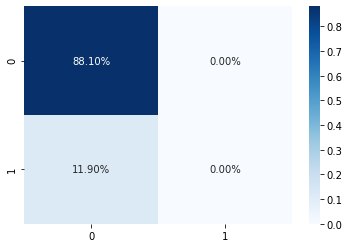

In [78]:
from sklearn.metrics import confusion_matrix

cf_matrix_lr = confusion_matrix(y_test, response_pred)
sns.heatmap(cf_matrix_lr/np.sum(cf_matrix_lr), annot=True, fmt='.2%', cmap='Blues')


In [79]:
from sklearn.metrics import precision_score, recall_score, f1_score

print(precision_score(y_test, response_pred, pos_label=1))
print(recall_score(y_test, response_pred, pos_label=1))
print(f1_score(y_test, response_pred, pos_label=1))

0.0
0.0
0.0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [80]:
# Accuracy score of the Logistic Regression:
from sklearn.metrics import accuracy_score

print('Accuracy score of the logistic regression is: ', logistic_model.score(X_test, y_test))

Accuracy score of the logistic regression is:  0.881


In [81]:
# another way of accuracy score:
print ('accuracy score is: ', accuracy_score(y_test, response_pred))


accuracy score is:  0.881


I applied the Logistic Regression to the StandardScaled data, but the result did not improve, so i applied the FeatureScaled data to see the improvement:

In [82]:
y=insurance_3['Response']

X=insurance_3[['Age', 'Annual_Premium', 'Policy_Sales_Channel','Vintage',
               'Gender','Driving_License', 'Previously_Insured', 
               'Vehicle_Damage', '1-2 Year', '> 2 Years']]

X_train_fs, X_test_fs, y_train_fs, y_test_fs = train_test_split(X, y, test_size=0.3, random_state=100)


In [83]:
log_reg_fs = LogisticRegression().fit(X_train_fs, y_train_fs)
log_reg_fs_predict = log_reg_fs.predict(X_test_fs)

y_fs_pred = pd.Series(log_reg_fs_predict).value_counts()
y_fs_pred

0    8999
1       1
dtype: int64

### In order to improve the model performance, we emply the decision tree model on the original data set without transormation

In [84]:
# use of original data:
from sklearn.tree import DecisionTreeClassifier

decision_reg = DecisionTreeClassifier(random_state=100).fit(X_train, y_train)
decision_predict = decision_reg.predict(X_test)

response_precidt = pd.Series(decision_predict, name='response_pred').value_counts()

In [85]:
pd.concat([y_tes, response_precidt], axis=1)


,Response,response_pred
0,5286,5215
1,714,785


In [86]:
decision_reg.score(X_test, y_test)

0.8251666666666667

In [87]:
accuracy_score(y_test, decision_predict)

0.8251666666666667

## Model Evaluation

### Creatre Confusion_matrix for Decision Tree

In [88]:

cf_matrix = confusion_matrix(y_test, decision_predict)
print(cf_matrix)

[[4726  560]
 [ 489  225]]


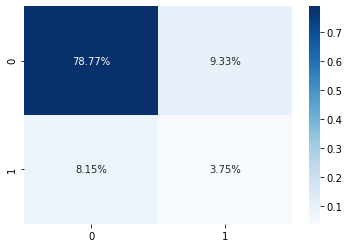

In [89]:
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')


In [90]:
# We need to assign which is the 'positive class'. Here, we are trying to predict whether a customer will run into
# problems repaying their loan. So Status B is the 'positive' class (meaning credit problems = True)
print(precision_score(y_test, decision_predict, pos_label=1))
print(recall_score(y_test, decision_predict, pos_label=1))
print(f1_score(y_test, decision_predict, pos_label=1))

0.28662420382165604
0.31512605042016806
0.3002001334222815


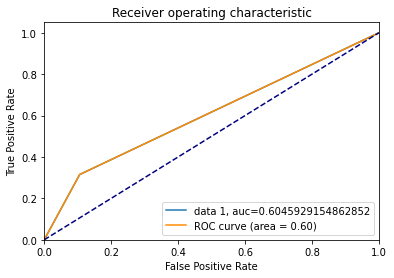

In [91]:
# ROC for Decision Tree

from sklearn.metrics import roc_auc_score, roc_curve

y_pred_proba = decision_reg.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### DecisionTree model on FeatureScaled data:



In [92]:
# use of normalised data:
dt_fs_data= DecisionTreeClassifier(random_state=100).fit(X_train_fs, y_train_fs)
dt_fs_predict = dt_fs_data.predict(X_test_fs)
dt_fs_pred = pd.Series(dt_fs_predict).value_counts()
dt_fs_pred

0    7864
1    1136
dtype: int64

In [93]:
# confusion_matrix

cf_matrix_dt_fs = confusion_matrix(y_test_fs, dt_fs_predict)
print(cf_matrix_dt_fs)

[[7061  825]
 [ 803  311]]


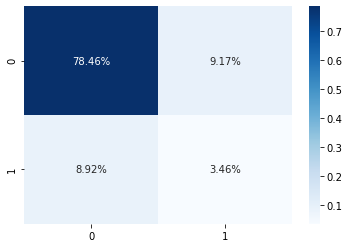

In [94]:

sns.heatmap(cf_matrix_dt_fs/np.sum(cf_matrix_dt_fs), annot=True, fmt='.2%', cmap='Blues')

In [95]:
print(precision_score(y_test_fs, dt_fs_predict, pos_label=1))
print(recall_score(y_test_fs, dt_fs_predict, pos_label=1))
print(f1_score(y_test_fs, dt_fs_predict, pos_label=1))

0.2737676056338028
0.2791741472172352
0.27644444444444444


### Dealing with imbalanced data - Under Sampling
https://towardsdatascience.com/how-to-deal-with-imbalanced-data-in-python-f9b71aba53eb 
Random Undersampling:
Random undersampling reduces the number of majority class randomly down to the desired ratio against the minority class. This is probably the easiest way to undersample and can actually yield good results if there are a lot of the majority class instances that are close to each other.


However, most researches have pointed out that undersampling in most cases does produce better results than oversampling. In industrial practice, it has been reported that tech giants like Facebook and Microsoft also tend to use undersampling method when it comes to classifying their ad performance. The common argument is that undersampling is generally “cheaper” than oversampling and since the class of interest is the minority positive class, reducing some information of the majority negative class is acceptable. Once you have a well-balanced data, your model will potentially learn to classify different classes better for a more reliable prediction.

In [96]:
# to install imblearn:
#pip install imblearn

In [97]:
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
import warnings 
warnings.simplefilter(action='ignore', category=FutureWarning)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=100)# test size should be small in under sampling


In [98]:
# apply the UnderSampling on original data:
# summarize class distribution
print("Before undersampling: ", Counter(y_train))

Before undersampling:  Counter({0: 23652, 1: 3348})


In [99]:
# define undersampling strategy
undersample = RandomUnderSampler(sampling_strategy='majority')

In [100]:
# fit and apply the transform
X_train_under, y_train_under = undersample.fit_resample(X_train, y_train)

In [101]:
# summarize class distribution
print("After undersampling: ", Counter(y_train_under))
#PART 2
# import SVM libraries 
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_auc_score

model=SVC()
clf_under = model.fit(X_train_under, y_train_under)
pred_under = clf_under.predict(X_test)

print("ROC AUC score for undersampled data: ", roc_auc_score(y_test, pred_under))

After undersampling:  Counter({0: 3348, 1: 3348})
ROC AUC score for undersampled data:  0.7895341147932705


In [102]:
X_test.shape

(3000, 10)

In [103]:
X_train_under.shape

(6696, 10)

### Application of Logistic Regression on the original data that has been UnderSampled:


In [108]:
    
logistic_model_u=LogisticRegression().fit(X_train_under, y_train_under)
response_pred_u=logistic_model_u.predict(X_test)
response_pred_u = pd.Series(response_pred_u)

y_pred_u = pd.Series(response_pred_u, name='response_pred').value_counts()
y_tes = y_test.value_counts()

print(y_pred_u)
print(precision_score(y_test, response_pred_u, pos_label=1))
print(recall_score(y_test, response_pred_u, pos_label=1))
print(f1_score(y_test, response_pred_u, pos_label=1))

0    1568
1    1432
Name: response_pred, dtype: int64
0.2479050279329609
0.9673024523160763
0.3946637020566982


Low precision relates to a high false positive rate, and high recall relates to a low false negative rate.

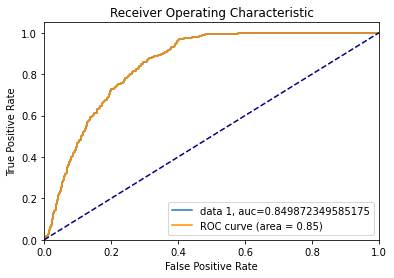

In [106]:
# ROC for Logistic regression when undersampled:

y_pred_proba = logistic_model_u.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### Application of  Decision Tree on the original data that has been UnderSampled:


In [48]:
dt_under= DecisionTreeClassifier(random_state=100).fit(X_train_under, y_train_under)
dt_under_predict = dt_under.predict(X_test)
dt_pred = pd.Series(dt_under_predict).value_counts()
dt_pred

0    2016
1     984
dtype: int64

In [49]:
print("Accuracy:", accuracy_score(y_test, dt_under_predict))

print(precision_score(y_test, dt_under_predict, pos_label=1))
print(recall_score(y_test, dt_under_predict, pos_label=1))
print(f1_score(y_test, dt_under_predict, pos_label=1))

Accuracy: 0.719
0.258130081300813
0.6920980926430518
0.37601776461880093


### Dealing with imbalanced data - Over Sampling


For over-sampling techniques, SMOTE (Synthetic Minority Oversampling Technique) is considered as one of the most popular and influential data sampling algorithms in ML and data mining. With SMOTE, the minority class is over-sampled by creating “synthetic” examples rather than by over-sampling with replacement. These introduced synthetic examples are based along the line segments joining a defined number of k minority class nearest neighbours, which is in the imblearn package is set at five by default.


In [50]:
# define oversampling strategy
y=insurance_1['Response']

X=insurance_1[['Age', 'Region_Code', 'Annual_Premium', 'Policy_Sales_Channel','Vintage',
               'Gender','Driving_License', 'Previously_Insured', 
               'Vehicle_Damage', '1-2 Year', '> 2 Years']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

from imblearn.over_sampling import SMOTE

SMOTE = SMOTE()

# fit and apply the transform
X_train_SMOTE, y_train_SMOTE = SMOTE.fit_resample(X_train, y_train)

# summarize class distribution
print("After oversampling: ",Counter(y_train_SMOTE))

After oversampling:  Counter({0: 18399, 1: 18399})


In [51]:
# performance of the newly fitted model:
"""model=SVC()
clf_SMOTE = model.fit(X_train_SMOTE, y_train_SMOTE)
pred_SMOTE = clf_SMOTE.predict(X_test)

print("ROC AUC score for oversampled SMOTE data: ", roc_auc_score(y_test, pred_SMOTE))"""

'model=SVC()\nclf_SMOTE = model.fit(X_train_SMOTE, y_train_SMOTE)\npred_SMOTE = clf_SMOTE.predict(X_test)\n\nprint("ROC AUC score for oversampled SMOTE data: ", roc_auc_score(y_test, pred_SMOTE))'

### Application of Logistic Regression on the original data that has been OverSampled:


In [52]:
logistic_model_o=LogisticRegression().fit(X_train_SMOTE, y_train_SMOTE)
response_pred_o=logistic_model_o.predict(X_test)
response_pred_o = pd.Series(response_pred_o)

y_pred_o = pd.Series(response_pred_o, name='response_pred').value_counts()
y_tes = y_test.value_counts()

print(y_pred_o)
print("Accuracy:", accuracy_score(y_test, response_pred_o))

print(precision_score(y_test, response_pred_o, pos_label=1))
print(recall_score(y_test, response_pred_o, pos_label=1))
print(f1_score(y_test, response_pred_o, pos_label=1))

0    4770
1    4230
Name: response_pred, dtype: int64
Accuracy: 0.6431111111111111
0.2520094562647754
0.9569120287253142
0.39895209580838326


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


High precision relates to a low false positive rate, and high recall relates to a low false negative rate.

### ROC Curve for OverSampling
Receiver Operating Characteristic(ROC) curve is a plot of the true positive rate against the false positive rate. It shows the tradeoff between sensitivity and specificity.

Example of Receiver Operating Characteristic (ROC) metric to evaluate classifier output quality.

ROC curves typically feature true positive rate on the Y axis, and false positive rate on the X axis. This means that the top left corner of the plot is the “ideal” point - a false positive rate of zero, and a true positive rate of one. This is not very realistic, but it does mean that a larger area under the curve (AUC) is usually better.

The “steepness” of ROC curves is also important, since it is ideal to maximize the true positive rate while minimizing the false positive rate.

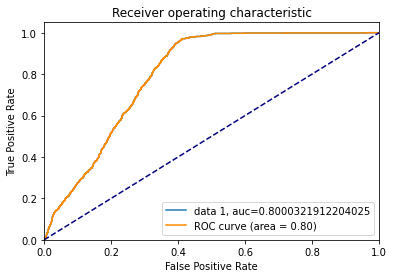

In [53]:
# ROC for Logistic Regression for Over Sample data:
from sklearn.metrics import roc_auc_score, roc_curve

y_pred_proba = logistic_model_o.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()


### A combination of under- and oversampling method using pipeline

In [185]:
# we need all the libraries in UnderSampling and OverSampling as well as below libraries.

# import sampling and other necessary libraries 
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
# define pipeline
model = SVC()
over = SMOTE(sampling_strategy=0.4)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o', over), ('u', under), ('model', model)]
pipeline = Pipeline(steps=steps)

In [186]:
#PART 2
# import libraries for evaluation
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from numpy import mean

# evaluate pipeline
scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=5, n_jobs=-1)
score = mean(scores)
print('ROC AUC score for the combined sampling method: %.3f' % score)

ROC AUC score for the combined sampling method: 0.532


Here is the codes to create a pipeline to resample the data using both under- and oversampling method.The list of possible ratios for oversampling is [0.3,0.4] while for undersampling [0.7,0.6].

In [78]:
# values to evaluate
"""over_values = [0.3,0.4]
under_values = [0.7,0.6]
for o in over_values:
  for u in under_values:
    # define pipeline
    model = SVC()
    over = SMOTE(sampling_strategy=o)
    under = RandomUnderSampler(sampling_strategy=u)
    steps = [('over', over), ('under', under), ('model', model)]
    pipeline = Pipeline(steps=steps)
    # evaluate pipeline
    scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=5, n_jobs=-1)
    score = mean(scores)
    print('SMOTE oversampling rate:%.1f, Random undersampling rate:%.1f , Mean ROC AUC: %.3f' % (o, u, score))
"""

"over_values = [0.3,0.4]\nunder_values = [0.7,0.6]\nfor o in over_values:\n  for u in under_values:\n    # define pipeline\n    model = SVC()\n    over = SMOTE(sampling_strategy=o)\n    under = RandomUnderSampler(sampling_strategy=u)\n    steps = [('over', over), ('under', under), ('model', model)]\n    pipeline = Pipeline(steps=steps)\n    # evaluate pipeline\n    scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=5, n_jobs=-1)\n    score = mean(scores)\n    print('SMOTE oversampling rate:%.1f, Random undersampling rate:%.1f , Mean ROC AUC: %.3f' % (o, u, score))\n"

In [79]:
#Here is the results of aboe combined model:
"""SMOTE oversampling rate:0.3, Random undersampling rate:0.7 , Mean ROC AUC: 0.630
SMOTE oversampling rate:0.3, Random undersampling rate:0.6 , Mean ROC AUC: 0.647
SMOTE oversampling rate:0.4, Random undersampling rate:0.7 , Mean ROC AUC: 0.632
SMOTE oversampling rate:0.4, Random undersampling rate:0.6 , Mean ROC AUC: 0.637"""

'SMOTE oversampling rate:0.3, Random undersampling rate:0.7 , Mean ROC AUC: 0.630\nSMOTE oversampling rate:0.3, Random undersampling rate:0.6 , Mean ROC AUC: 0.647\nSMOTE oversampling rate:0.4, Random undersampling rate:0.7 , Mean ROC AUC: 0.632\nSMOTE oversampling rate:0.4, Random undersampling rate:0.6 , Mean ROC AUC: 0.637'

As seen in the output snapshot, the best sampling ratio in this example is to have an oversampling ratio of 0.3, follows by an undersampling ratio of 0.6 for the best possible mean ROC AUC score at 64.7%.